In [1]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import loompy as lp
#from MulticoreTSNE import MulticoreTSNE as TSNE
import os
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
sc.settings.verbosity = 3

In [3]:
# set variables for file paths to read from and write to:

# set a working directory
#os.chdir( mainDir )

# # path to loom file with basic filtering applied (this will be created in the "initial filtering" step below). Optional.
f_loom_path_scenic = "filtered_scenic.loom"

# path to pyscenic output
f_pyscenic_output = "pyscenic_output.loom"

# loom output, generated from a combination of Scanpy and pySCENIC results:
f_final_loom = 'scenic_integrated-output.loom'

# Expression data import

In [4]:
#import raw adata with full genes

In [5]:
adata = sc.read("221212.dermis.renorm.raw(copy).e13_pd4.concatenated.gene1000.mt7.5.h5ad")

Only considering the two last: ['.5', '.h5ad'].
Only considering the two last: ['.5', '.h5ad'].


In [6]:
adata

AnnData object with n_obs × n_vars = 44416 × 21979
    obs: 'orig.ident', 'nCount_originalexp', 'nFeature_originalexp', 'nCount_RNA', 'nFeature_RNA', 'ident', 'scDblFinder.class', 'scDblFinder.score', 'scDblFinder.weighted', 'scDblFinder.cxds_score', 'bulk.ident', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes', '_scvi_batch', '_scvi_labels', 'leiden_scVI_0.2', 'leiden_scVI_0.3', 'leiden_scVI_0.4', 'leiden_scVI_0.5', 'leiden_scVI_0.6', 'leiden_scVI_0.7', 'leiden_scVI_0.8', 'leiden_scVI_0.9', 'leiden_scVI_1.0', 'leiden_scVI_1.5'
    var: 'scDblFinder.selected-0', 'scDblFinder.selected-1', 'scDblFinder.selected-10', 'scDblFinder.selected-2', 'scDblFinder.selected-3', 'scDblFinder.selected-4', 'scDblFinder.selected-5', 'scDblFinder.selected-6', 'scDblFinder.selected-7', 'scDblFinder.selected-8', 'scDblFinder.selected-9', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
    uns: 'leiden_scVI_0.9_colors'

In [7]:
X_scVI_umap = np.load("UMAP.npy")
X_scVI_clust = pd.read_csv("clustering.csv", index_col=0)
adata.obsm["X_umap"] = X_scVI_umap
adata.obs["sub_cluster3"] = X_scVI_clust["sub_cluster3"].astype("string") ## category, string, number matters!

/Users/ihanjae/anaconda3/envs/pyscenic/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:369: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/Users/ihanjae/anaconda3/envs/pyscenic/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:379: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/Users/ihanjae/anaconda3/envs/pyscenic/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


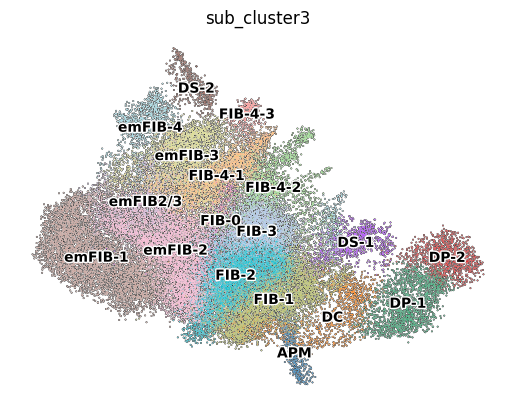

In [8]:
sc.pl.umap(
    adata,
    color=["sub_cluster3"],
    frameon=False, add_outline=True, legend_loc='on data',legend_fontoutline=2
)

In [9]:
adata.X = adata.layers['counts']

In [ ]:
# create basic row and column attributes for the loom file:
row_attrs = {
    "Gene": np.array(adata.var_names) ,
}
col_attrs = {
    "CellID": np.array(adata.obs_names) ,
    "nGene": np.array( np.sum(adata.X.transpose()>0 , axis=0)).flatten() ,
    "nUMI": np.array( np.sum(adata.X.transpose() , axis=0)).flatten() ,
}
lp.create(f_loom_path_scenic, adata.X.transpose(), row_attrs, col_attrs)

In [ ]:
# transcription factors list
# f_tfs = "/ddn1/vol1/staging/leuven/stg_00002/lcb/cflerin/resources/allTFs_hg38.txt" # human
# f_tfs = "/ddn1/vol1/staging/leuven/stg_00002/lcb/cflerin/resources/allTFs_dmel.txt" # drosophila
f_tfs = "/Users/ihanjae/Informatics/Tools/pyscenic/Mouse/allTFs_mm.txt"   # mouse
# tf_names = load_tf_names( f_tfs )

In [ ]:
!~/anaconda3/envs/pyscenic/bin/arboreto_with_multiprocessing.py \
    {f_loom_path_scenic} \
    {f_tfs} \
    --method grnboost2 \
    --output adj.csv \
    --num_workers 5 \
    --seed 777

Loaded expression matrix of 44416 cells and 21979 genes in 24.849740028381348 seconds...
Loaded 1860 TFs...
starting grnboost2 using 5 processes...
 74%|██████████████████████▎       | 16336/21979 [102:48:28<27:04:43, 17.28s/it]

In [10]:
results_adjacencies = pd.read_csv("adj.csv", index_col=False, sep=",")
print(f"Number of associations: {results_adjacencies.shape[0]}")
results_adjacencies.head()

Number of associations: 7518422


,TF,target,importance
0,Rpl35,Gm10076,709.646199
1,Rpl35,Uba52,543.146408
2,Rpl35,Rps27,540.427688
3,Rps10,Tpt1,507.236211
4,Rps10,Rps24,487.883415


(-10.0, 10.0)

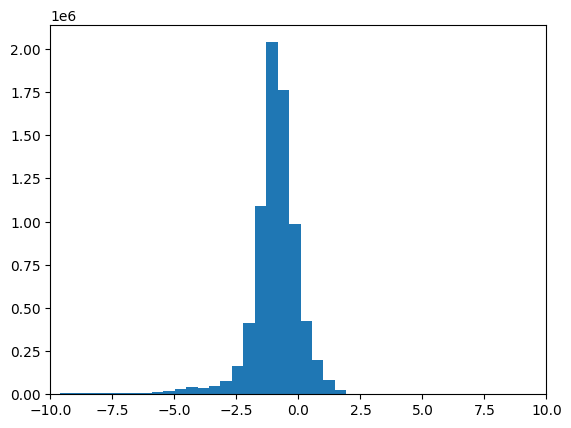

In [11]:
plt.hist(np.log10(results_adjacencies["importance"]), bins=50)
plt.xlim([-10, 10])

In [27]:
import glob
import os

# ranking databases
db_glob = "/Users/ihanjae/Informatics/Tools/pyscenic/Mouse/mm10_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings.feather"
db_names = " ".join(glob.glob(db_glob))

In [28]:
# motif databases
motif_path = "/Users/ihanjae/Informatics/Tools/pyscenic/Mouse/motifs-v10nr_clust-nr.mgi-m0.001-o0.0.tbl"

In [ ]:
!~/anaconda3/envs/pyscenic/bin/pyscenic ctx adj.csv \
    {db_names} \
    --annotations_fname {motif_path} \
    --expression_mtx_fname {f_loom_path_scenic} \
    --output reg.csv \
    --mask_dropouts \
    --num_workers 5

In [12]:
import numpy as np

n_genes_detected_per_cell = np.sum(adata.X > 0, axis=1)
percentiles = pd.Series(n_genes_detected_per_cell.flatten().A.flatten()).quantile(
    [0.01, 0.05, 0.10, 0.50, 1]
)
print(percentiles)

0.01    1070.0
0.05    1297.0
0.10    1524.0
0.50    2491.0
1.00    6953.0
dtype: float64


/var/folders/m_/379l60h52vjg8c1k_rrkmdpw0000gn/T/ipykernel_24839/1384461256.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(n_genes_detected_per_cell, norm_hist=False, kde=False, bins="fd")


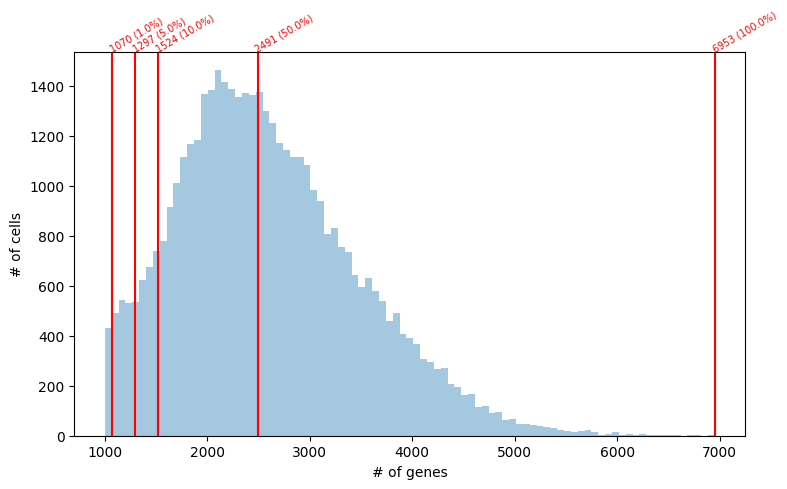

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5), dpi=100)
sns.distplot(n_genes_detected_per_cell, norm_hist=False, kde=False, bins="fd")
for i, x in enumerate(percentiles):
    fig.gca().axvline(x=x, ymin=0, ymax=1, color="red")
    ax.text(
        x=x,
        y=ax.get_ylim()[1],
        s=f"{int(x)} ({percentiles.index.values[i]*100}%)",
        color="red",
        rotation=30,
        size="x-small",
        rotation_mode="anchor",
    )
ax.set_xlabel("# of genes")
ax.set_ylabel("# of cells")
fig.tight_layout()

In [ ]:
!~/anaconda3/envs/pyscenic/bin/pyscenic aucell \
    {f_loom_path_scenic} \
    reg.csv \
    --output {f_pyscenic_output} \
    --num_workers 5

In [14]:
import json
import zlib
import base64

# collect SCENIC AUCell output
lf = lp.connect(f_pyscenic_output, mode="r+", validate=False)
auc_mtx = pd.DataFrame(lf.ca.RegulonsAUC, index=lf.ca.CellID)
regulons = lf.ra.Regulons
lf.close()

In [15]:
import anndata as ad

ad_auc_mtx = ad.AnnData(auc_mtx)
sc.pp.neighbors(ad_auc_mtx, n_neighbors=10, metric="correlation")
sc.tl.umap(ad_auc_mtx)

computing neighbors
         Falling back to preprocessing with `sc.pp.pca` and default params.
computing PCA
    with n_comps=50
    finished (0:00:36)


/Users/ihanjae/anaconda3/envs/pyscenic/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:47)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:14)


In [16]:
adata.obsm["X_umap_aucell"] = ad_auc_mtx.obsm["X_umap"]

/Users/ihanjae/anaconda3/envs/pyscenic/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


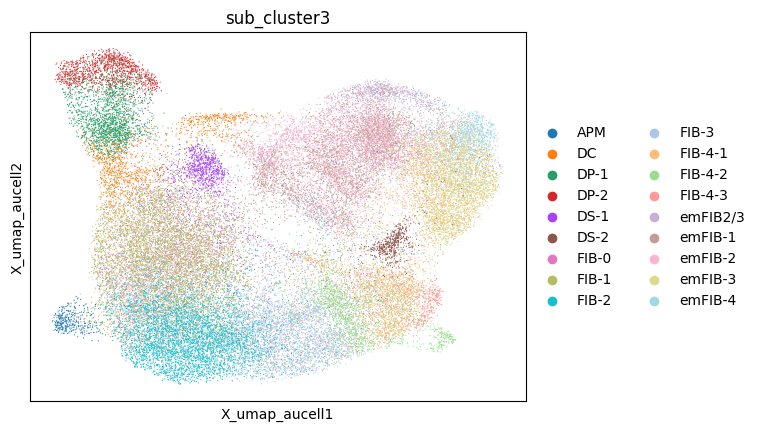

In [17]:
sc.pl.embedding(adata, basis="X_umap_aucell", color="sub_cluster3")

In [33]:
from pyscenic.rss import regulon_specificity_scores
from pyscenic.plotting import plot_rss
import matplotlib.pyplot as plt
from adjustText import adjust_text
import seaborn as sns
from pyscenic.binarization import binarize

In [34]:
rss_cellType = regulon_specificity_scores( auc_mtx, adata.obs["sub_cluster3"] )
rss_cellType

,Aff4_(+),Alx1_(+),Alx3_(+),Alx4_(+),Arid3a_(+),Arnt_(+),Arnt2_(+),Arntl2_(+),Atf1_(+),Atf2_(+),...,Zfp595_(+),Zfp629_(+),Zfp704_(+),Zfp78_(+),Zfp82_(+),Zfp92_(+),Zfp961_(+),Zfp992_(+),Zfx_(+),Zgpat_(+)
emFIB-1,0.222367,0.194554,0.275877,0.252386,0.261543,0.194593,0.214252,0.235179,0.241318,0.198449,...,0.206513,0.192946,0.274341,0.248982,0.182568,0.270475,0.192299,0.176673,0.270720,0.215749
emFIB-4,0.209634,0.246601,0.212679,0.204148,0.190593,0.205371,0.185119,0.221317,0.208613,0.194879,...,0.235453,0.217329,0.204023,0.211717,0.189596,0.213144,0.192321,0.199166,0.209321,0.218816
emFIB2/3,0.211341,0.201042,0.199428,0.198523,0.196325,0.232175,0.210577,0.221476,0.206589,0.194227,...,0.226330,0.198866,0.208548,0.205725,0.194036,0.211185,0.175185,0.191072,0.219405,0.212158
emFIB-3,0.218889,0.248720,0.240830,0.218548,0.204103,0.216250,0.191825,0.243066,0.211135,0.218178,...,0.230914,0.218677,0.232519,0.229839,0.201445,0.235820,0.192257,0.193882,0.239823,0.223741
emFIB-2,0.256172,0.211258,0.302370,0.270160,0.268550,0.227365,0.233146,0.275465,0.232220,0.204204,...,0.241403,0.204001,0.290640,0.278084,0.199715,0.258290,0.193774,0.193144,0.295820,0.212313
FIB-4-1,0.237240,0.214797,0.224049,0.217580,0.191774,0.204152,0.190079,0.236363,0.226161,0.242424,...,0.218201,0.207669,0.241569,0.237041,0.200253,0.235038,0.177159,0.183597,0.246522,0.205300
FIB-1,0.275280,0.213867,0.266437,0.258266,0.308357,0.210991,0.214438,0.260672,0.233414,0.201756,...,0.222276,0.223366,0.288825,0.268326,0.200301,0.244532,0.182430,0.190563,0.284867,0.214965
FIB-3,0.275161,0.190249,0.242191,0.223694,0.214084,0.196100,0.190794,0.250794,0.254503,0.208351,...,0.210249,0.186188,0.278997,0.275940,0.213036,0.220032,0.182014,0.173926,0.265334,0.187082
DS-2,0.191844,0.211110,0.186582,0.180257,0.174453,0.188864,0.178833,0.187669,0.204610,0.185738,...,0.188092,0.175906,0.189109,0.188902,0.201206,0.189597,0.167935,0.173580,0.191793,0.202882
DC,0.219555,0.186736,0.214158,0.242730,0.243897,0.193612,0.225187,0.205428,0.206267,0.179403,...,0.200680,0.224852,0.205762,0.206418,0.183298,0.200087,0.172851,0.188827,0.210597,0.200451


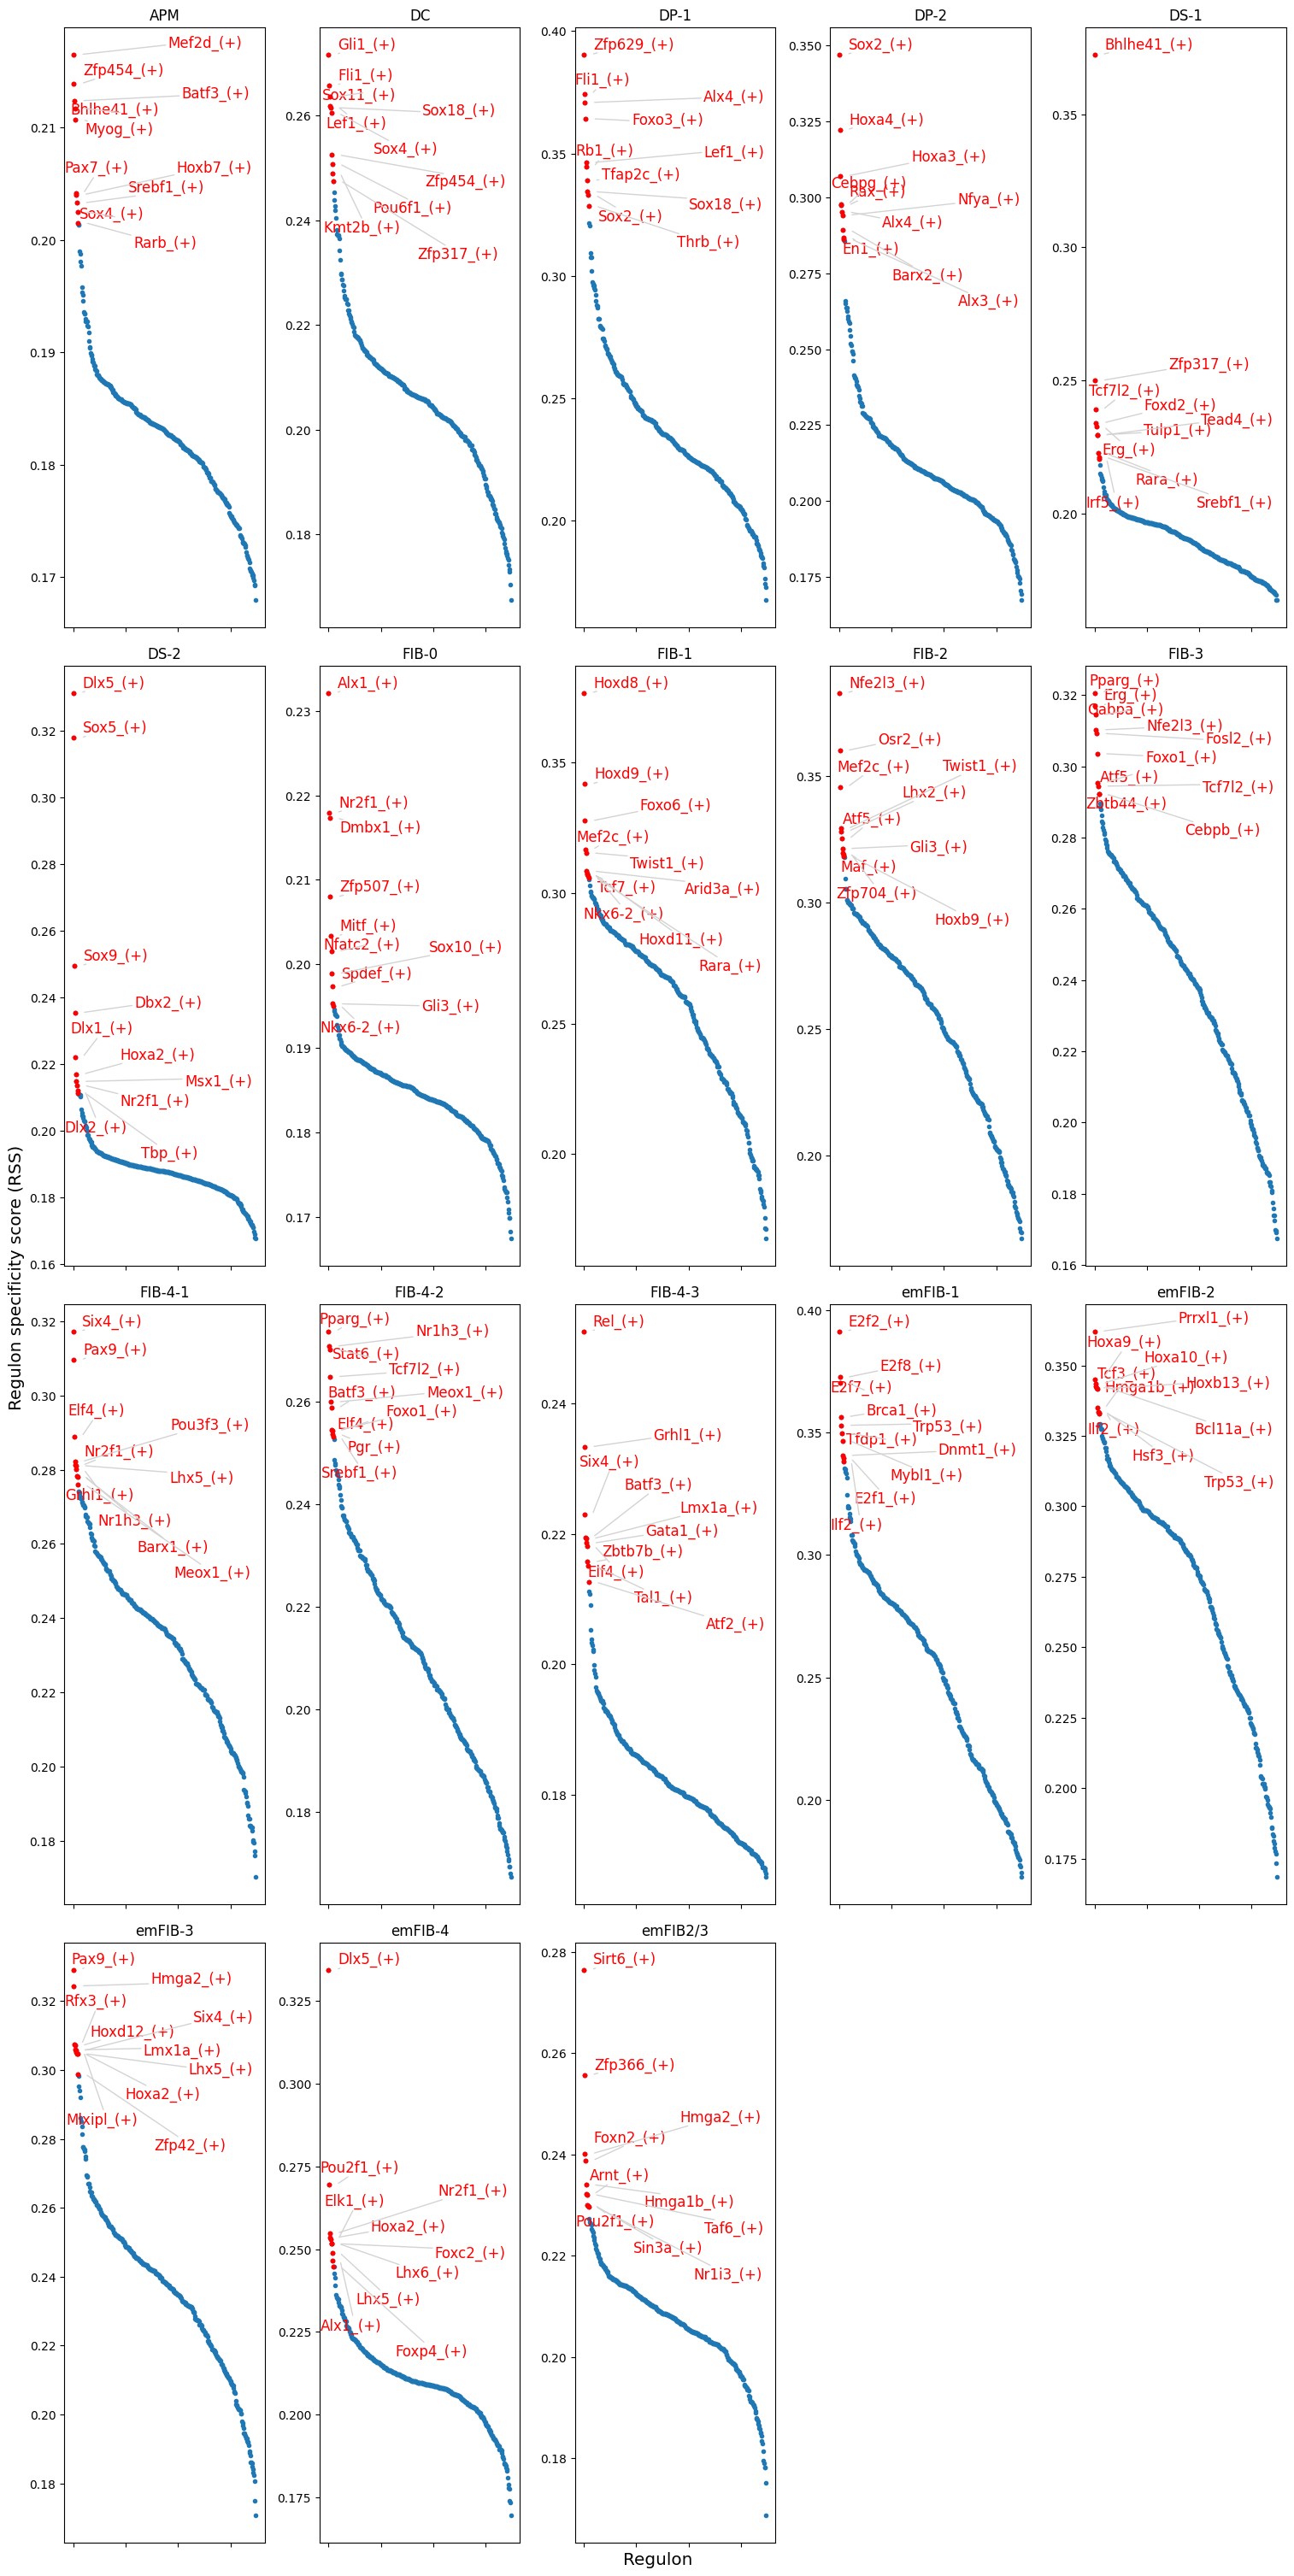

In [35]:
cats = sorted(list(set(adata.obs["sub_cluster3"])))

fig = plt.figure(figsize=(15, 30))
for c,num in zip(cats, range(1,len(cats)+1)):
    x=rss_cellType.T[c]
    ax = fig.add_subplot(4,5,num)
    plot_rss(rss_cellType, c, top_n=10, max_n=None, ax=ax)
    ax.set_ylim( x.min()-(x.max()-x.min())*0.05 , x.max()+(x.max()-x.min())*0.05 )
    for t in ax.texts:
        t.set_fontsize(12)
    ax.set_ylabel('')
    ax.set_xlabel('')
    adjust_text(ax.texts, autoalign='xy', ha='right', va='bottom', arrowprops=dict(arrowstyle='-',color='lightgrey'), precision=0.001 )
 
fig.text(0.5, 0.0, 'Regulon', ha='center', va='center', size='x-large')
fig.text(0.00, 0.5, 'Regulon specificity score (RSS)', ha='center', va='center', rotation='vertical', size='x-large')
plt.tight_layout()
plt.rcParams.update({
    'figure.autolayout': True,
        'figure.titlesize': 'large' ,
        'axes.labelsize': 'medium',
        'axes.titlesize':'large',
        'xtick.labelsize':'medium',
        'ytick.labelsize':'medium'
        })
plt.savefig("top10.pdf", dpi=600, bbox_inches = "tight")
plt.show()